<a href="https://colab.research.google.com/github/dhruvshah01/cs666student/blob/main/CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

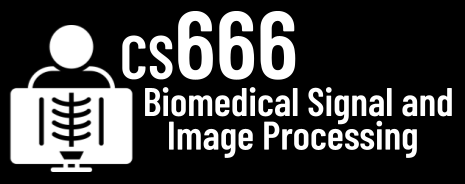
#Assignment 4

In [ ]:
# NAME: Dhruv Shah

In [ ]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [45]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [46]:
# we are using mahotas again, so lets install it!
!pip install mahotas

In [47]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [ ]:
# Please download this file: https://cs666.org/data/xray/ with the wget command!
# Note: Please use the forwarded dropbox link and change dl=0 to dl=1!
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
!wget https://www.dropbox.com/s/2ca2889o2ql8n4e/xray.zip?dl=1

--2024-03-31 03:55:43--  https://www.dropbox.com/s/2ca2889o2ql8n4e/xray.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/2ca2889o2ql8n4e/xray.zip [following]
--2024-03-31 03:55:43--  https://www.dropbox.com/s/raw/2ca2889o2ql8n4e/xray.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7ff5a5c6d03ef7d130765cda82.dl.dropboxusercontent.com/cd/0/inline/CQE_3khfEQpIhn1wZOXT2YUhwBcRrOiuOUwZzjT47TmBmYF3u83r84EIyus30MEmj5HkbHckq4_3Ef8qHQqaxdujLlf1qtJ3G0nCAwefv6TMlI3jCESrsqMmBhn-ohgQbw8/file# [following]
--2024-03-31 03:55:44--  https://uc7ff5a5c6d03ef7d130765cda82.dl.dropboxusercontent.com/cd/0/inline/CQE_3khfEQpIhn1wZOXT2YUhwBcRrOiuOUwZzjT47TmBmYF3u83r84EIyus30MEmj5HkbHckq4_3Ef8qHQqaxdujLlf1qtJ3G0nCAwefv6TMlI3jCESrsqMmBhn-ohgQ

In [48]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip?dl=1', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [49]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [ ]:
# TODO: Please display this image and print the dimensions!

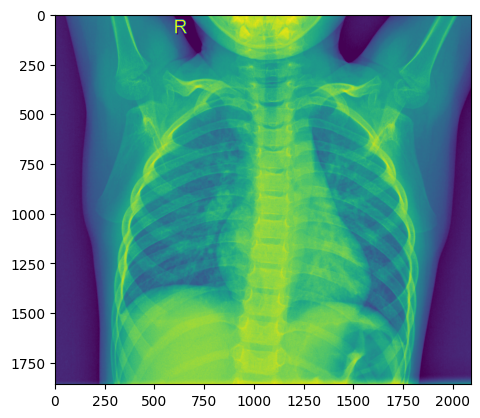

In [50]:
# TODO: YOUR CODE
imshow(img)

In [52]:
print(f"Image Dimensions {img.shape}")

Image Dimensions (1858, 2090)


**Task 2:** Let's do some data wrangling and more visualization! [30 Points]

In [53]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [ ]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) To begin with, the code reads the image based on the different folders present
# TODO: Operation 2) Transforms color images to grayscale and resized to 300, 300
# TODO: Operation 3) Image is stored appropriately ensuring consistency

In [ ]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

<Figure size 640x480 with 0 Axes>

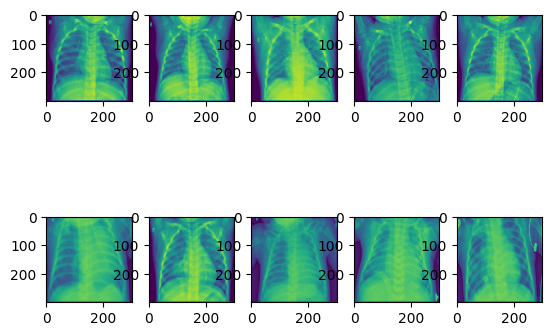

In [ ]:
# TODO: YOUR CODE
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,5)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(5):
  axarr[0, i].imshow(data[0][i])
  axarr[1, i].imshow(data[1][i])

**Task 3:** Setup training and testing data. [15 Points]

In [ ]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [ ]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [ ]:
# TODO: Please create the y_train vector with 0 for a normal image,
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_train = np.array([0] * TRAINING_COUNT + [1] * TRAINING_COUNT + [2] * TRAINING_COUNT)

In [ ]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [ ]:
# TODO: Please create the y_test vector with 0 for a normal image,
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_test = np.array([0] * TESTING_COUNT + [1] * TESTING_COUNT + [2] * TESTING_COUNT)

**Task 4:** Let's train and evaluate the Random Forest! [30 Points]

In [ ]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [ ]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [ ]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [ ]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [ ]:
# TODO: YOUR ANSWER

Random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction.

In [ ]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [ ]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [ ]:
# TODO: YOUR ANSWER

Definitely a good classification result. I am a bit surprised considering how simple model works really well on an image based dataset.

**Task 5:** Now, let's decrease the number of trees! [10 Points]

In [ ]:
# How many trees are used in Task 4?

In [ ]:
params = clf.get_params()
for param, value in params.items():
    print(f"{param}: {value}")

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [ ]:
# TODO: 100 Trees

In [ ]:
# Now, please use a single tree and observe the testing performance.

In [ ]:
# TODO: YOUR CODE
one_tree_clf = RandomForestClassifier(n_estimators = 1)

In [ ]:
one_tree_fitted = one_tree_clf.fit(X_train, y_train)

In [ ]:
one_tree_clf.score(X_test, y_test)

0.9

In [ ]:
# Are you surprised?

In [ ]:
# TODO: Yes a little bit. I was not expecting such high score but again such a versatile algorithm, makes me really proud of it!

**Bonus:** Let's take a closer look! [33 Points]

In [ ]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [ ]:
# TODO: YOUR CODE AND YOUR ANSWER

In [ ]:
remaining_data = np.zeros( (99, 300*300 ), dtype=np.float32)
t_pos = 0

for image in data[2][100:199]:
  image = image.ravel() # flatten the image
  image /= image.max() # normalize the image
  remaining_data[t_pos] = image
  t_pos += 1

remaining_y = np.array([2] * 99)

clf.score(remaining_data, remaining_y)


0.9393939393939394

In [ ]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?
# Do you have an idea why these images were problematic?

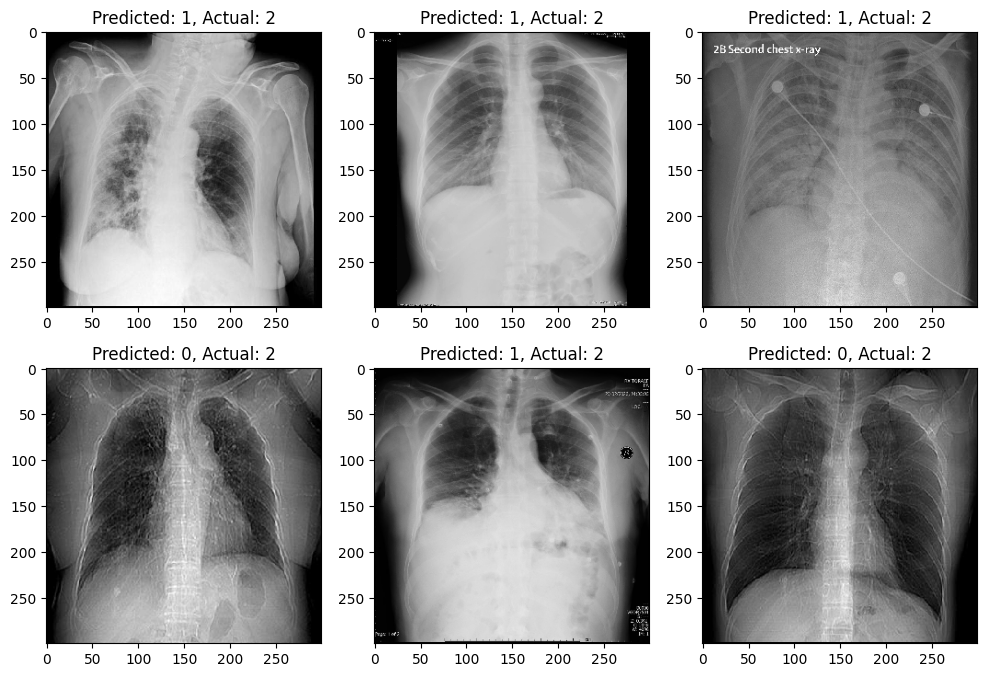

In [ ]:
predictions = clf.predict(remaining_data)
misclassified_indices = np.where(predictions != remaining_y)[0]

# Display the misclassified images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_indices):
  plt.subplot(3, 3, i + 1)
  plt.imshow(remaining_data[idx].reshape(300, 300), cmap='gray')
  plt.title(f"Predicted: {predictions[idx]}, Actual: {remaining_y[idx]}")
plt.tight_layout()
plt.show()


In [ ]:
# Why are these images problematic?
# TODO: The main reason would be that the data was unseen during training, as a result, the model was not generalized enough.


In [ ]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw